# PII Detection on Collection - MSFT Presidio Example
The following is an example of how to use the PIIAnalysisService with the default MSFT Presidio analyzer on a collection of text.

> Note: This notebook requires all dependencies to have been installed. For more information, review readme.


In [1]:
from pii_codex.models.common import AnalysisProviderType
from pii_codex.services.analysis_service import PIIAnalysisService
import pandas as pd

pii_analysis_service = PIIAnalysisService()

# Run the detection and assessments in one shot with the PIIAnalysisService
analysis_results = pii_analysis_service.analyze_collection(
    analysis_provider=AnalysisProviderType.PRESIDIO.name,
    texts=[
        "How can I reach you, Jim?",
        "Here is my contact information: Phone number 555-555-5555 and my email is example123@email.com",
        "Perfect, my number if you need me is 777-777-7777. Where is the residence and what is the earliest the crew can arrive?",
        "I'll be at my home at 123 Dark Data Lane, OH, 11111 after 7PM",
        "Cool, I'll be there!"
        ],
    language_code="en",
    collection_type="population",
    collection_name="PII Collection 1"
)

print("Collection Risk Score: ", analysis_results.risk_score_mean)

Collection Risk Score:  2.3333333333333335


Sometimes text analyses aren't enough. For those handling social media records, they may be provided with metadata that can be used in determining if the post contains other elements considered to be PII. For this, we expose a data parameter. Pass in a data frame with a text column (str) and a metadata column (dict) for each social media post.

In [2]:

analysis_results = pii_analysis_service.analyze_collection(
    analysis_provider=AnalysisProviderType.PRESIDIO.name,
    data=pd.DataFrame({
        "text": [
            "I attend the University of Central Florida, how about you?",
            "If anyone needs trig help, my phone number 555-555-5555 and my email is example123@email.com",
            "Oh I do! My number is 777-777-7777. Where is the residence hall?",
            "The dorm is over at 123 Dark Data Lane, OH, 11111",
            "Cool, I'll be there!"
        ],
        "metadata": [
            {"location": True, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
            {"location": False, "url": False, "screen_name": True}, # Not all social media posts will have location metadata
            {"location": False, "url": False, "screen_name": True},
            {"location": True, "url": False, "screen_name": True},
        ]
    }),
    language_code="en",
    collection_type="population",
    collection_name="PII Collection 1"
)

results = analysis_results.to_dict()
results

{'collection_name': 'PII Collection 1',
 'collection_type': 'POPULATION',
 'analyses': [{'analysis': [{'pii_type_detected': None,
     'risk_level': 1,
     'risk_level_definition': 'Non-Identifiable',
     'cluster_membership_type': None,
     'hipaa_category': None,
     'dhs_category': None,
     'nist_category': None},
    {'pii_type_detected': 'LOCATION',
     'risk_level': 2,
     'risk_level_definition': 'Semi-Identifiable',
     'cluster_membership_type': 'Secure Identifiers',
     'hipaa_category': 'Protected Health Information',
     'dhs_category': 'Not Mentioned',
     'nist_category': 'Linkable',
     'entity_type': 'LOCATION',
     'score': 0.0,
     'start': 0,
     'end': 0},
    {'pii_type_detected': 'SCREEN_NAME',
     'risk_level': 3,
     'risk_level_definition': 'Identifiable',
     'cluster_membership_type': 'Personal Preferences',
     'hipaa_category': 'Not Protected Health Information',
     'dhs_category': 'Not Mentioned',
     'nist_category': 'Directly PII',

In [3]:
# Peering into each and every analysis in collection
data = results.copy()
del data['analyses']

analyses_collection_df = pd.DataFrame(
    [data]
)

analyses_collection_df.T

,0
collection_name,PII Collection 1
collection_type,POPULATION
detection_count,15
risk_scores,"[2, 2.6, 3, 2.5, 2]"
risk_score_mean,2.42
risk_score_mode,2
risk_score_median,2.5
risk_score_standard_deviation,0.381576
risk_score_variance,0.1456
detected_pii_types,"[EMAIL_ADDRESS, SCREEN_NAME, URL, PHONE_NUMBER..."


In [4]:
analyses = results["analyses"]
analyses_df = pd.DataFrame(
    analyses
)
analyses_df["collection_name"] = results["collection_name"]
analyses_df

,analysis,index,risk_score_mean,collection_name
0,"[{'pii_type_detected': None, 'risk_level': 1, ...",0,2.0,PII Collection 1
1,"[{'pii_type_detected': 'EMAIL_ADDRESS', 'risk_...",1,2.6,PII Collection 1
2,"[{'pii_type_detected': 'PHONE_NUMBER', 'risk_l...",2,3.0,PII Collection 1
3,"[{'pii_type_detected': 'LOCATION', 'risk_level...",3,2.5,PII Collection 1
4,"[{'pii_type_detected': None, 'risk_level': 1, ...",4,2.0,PII Collection 1


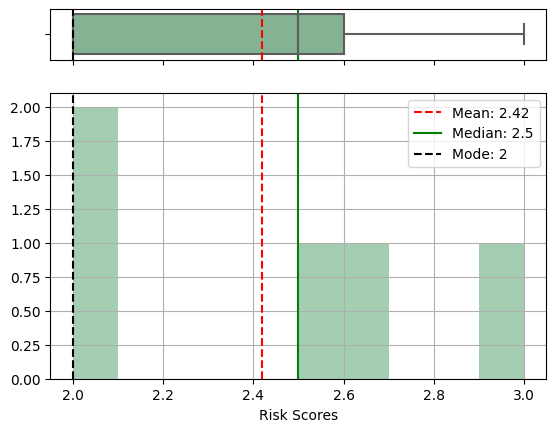

In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_palette(sns.color_palette("crest"))

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

mean=analyses_collection_df['risk_score_mean'].item()
median=analyses_collection_df['risk_score_median'].item()
mode=analyses_collection_df['risk_score_mode'].item()

sns.boxplot(data=analyses_df, x="risk_score_mean", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='green', linestyle='-')
ax_box.axvline(mode, color='black', linestyle='--')

ax_hist.hist(analyses_collection_df["risk_scores"], alpha = 0.7)
ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean: {round(mean, 2)}")
ax_hist.axvline(median, color='green', linestyle='-', label=f"Median: {round(median, 2)}")
ax_hist.axvline(mode, color='black', linestyle='--', label=f"Mode: {mode}")

ax_hist.set(xlabel='Risk Scores')
ax_hist.legend()

ax_box.set(xlabel='')
plt.grid()
plt.show()

In [6]:
detected_types = []
for detection in analyses_collection_df["detected_pii_type_frequencies"].item():
    detected_types.append({
        "Collection": analyses_collection_df["collection_name"].item(),
        "Detected PII Type": detection,
        "Count": analyses_collection_df["detected_pii_type_frequencies"].item()[detection]
    })

detected_types_df = pd.DataFrame(detected_types)
detected_types_df

,Collection,Detected PII Type,Count
0,PII Collection 1,LOCATION,4
1,PII Collection 1,SCREEN_NAME,5
2,PII Collection 1,EMAIL_ADDRESS,1
3,PII Collection 1,PHONE_NUMBER,2
4,PII Collection 1,URL,1


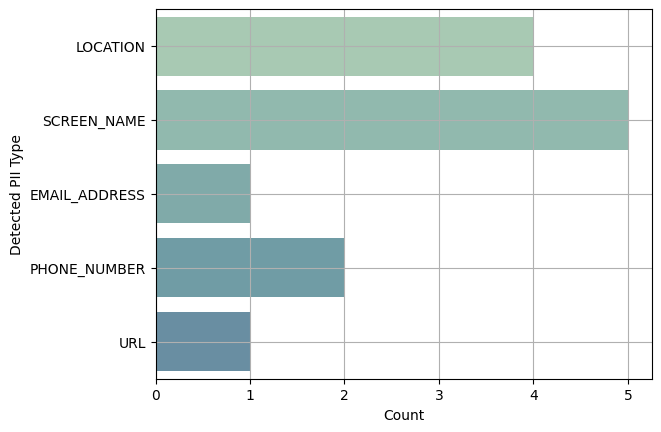

In [7]:
sns.barplot(data=detected_types_df, y="Detected PII Type", x="Count", alpha = 0.7)
plt.grid()